In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.random as rng
from scipy.special import expit as sigmoid
from math import log2
#from sklearn.neural_network import BernoulliRBM

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 50  # that's how many of EACH digit there is. Can go as high as... what, 5000?
current_digits = flatten_dataset(load_mnist_digit(0,dataset_size))
for i in [2,3]:
    current_digits = np.vstack((current_digits, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [63]:
print (current_digits.shape)
num_pats = current_digits.shape[0]
num_visibles = current_digits.shape[1]

(150, 784)


## Show some examples....

(150, 784)


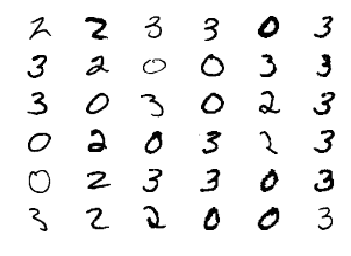

In [64]:
print(current_digits.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(current_digits[rng.randint(num_pats)].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

### Start from random initial weights and bias weights

In [65]:
v = current_digits
num_hiddens = 100
h = np.zeros(shape=(num_pats, num_hiddens), dtype=int)
W = rng.normal(0,1,size=(num_hiddens, num_visibles))
hidden_biases = rng.normal(size=(1, num_hiddens))
visible_biases = rng.normal(size=(1, num_visibles))
change = 0

### Do some learning, using CD1 (contrastive divergence)

In [74]:
num_iterations = 100
announce_every = num_iterations / 10
learning_rate, momentum = 0.005, 0.95
import time
start = time.time()
for t in range(num_iterations):
    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v, W.T) + hidden_biases)
    h_first = 1*(h_prob1 > rng.random(size=h_prob1.shape))
    
    # push hidden pats into visible 
    v_prob1 = sigmoid(np.dot(h_first, W) + visible_biases)
    v_reconstruction = v_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

    # push visible pats into hidden 
    h_prob1 = sigmoid(np.dot(v_reconstruction, W.T) + hidden_biases)
    h_second = 1*(h_prob1 > rng.random(size=h_prob1.shape))

    # THIS WAY IS REALLY MEMORY-INTENSIVE AND SLOW - USE EINSTEIN INSTEAD!
    # Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
    # AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

    # Einstein alternative suggested by Paul Mathews.
    Hebb = np.einsum('ij,ik->jk', h_first, v) 
    AntiHebb = np.einsum('ij,ik->jk', h_second, v_reconstruction) 
    
    change = learning_rate * (Hebb - AntiHebb)  +  momentum * change
    W += change
    if (t % announce_every == 0): 
        print ('Iteration %5d \t TIME (secs): %.1f ' % (t, time.time() - start))


Iteration     0 	 TIME (secs): 0.1 
Iteration    10 	 TIME (secs): 1.4 
Iteration    20 	 TIME (secs): 2.6 
Iteration    30 	 TIME (secs): 3.9 
Iteration    40 	 TIME (secs): 5.1 
Iteration    50 	 TIME (secs): 6.3 
Iteration    60 	 TIME (secs): 7.6 
Iteration    70 	 TIME (secs): 8.8 
Iteration    80 	 TIME (secs): 10.1 
Iteration    90 	 TIME (secs): 11.3 


### reality-check some of the latest Hebb updates 

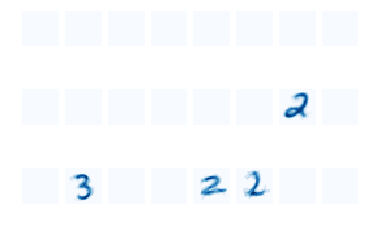

In [75]:
nr, nc = 3, 8
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(Hebb[i].reshape(28,28), interpolation='nearest',cmap='Blues')
    plt.axis('off')

### .... and some of the latest ANTI-Hebbian updates 

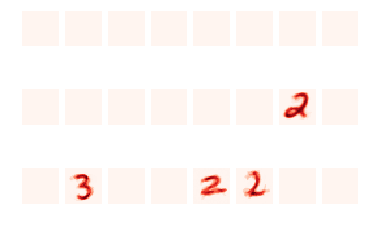

In [76]:
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(AntiHebb[i].reshape(28,28), interpolation='nearest',cmap='Reds')
    plt.axis('off')

## dreams
Will they ever make sense?

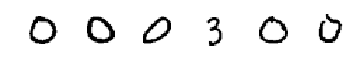

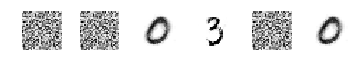

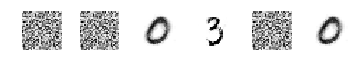

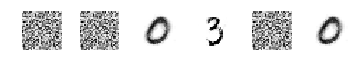

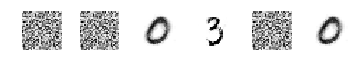

In [70]:
num_examples = 6
V_test = current_digits[rng.randint(0, num_pats, size=(6)), :]
i = 0
num_Gibbs = 0
for s in range(5):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        h_prob1 = sigmoid(np.dot(V_test, W.T) + hidden_biases)
        h = 1*(h_prob1 > rng.random(size=h_prob1.shape))
        # push hidden pats into visible 
        v_prob1 = sigmoid(np.dot(h, W) + visible_biases)
        V_test = v_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(5,num_examples,i)
        plt.imshow(V_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
    num_Gibbs = max(1, num_Gibbs * 15)  # wait longer before showing the next sample...
    plt.show()

So, we see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

## features

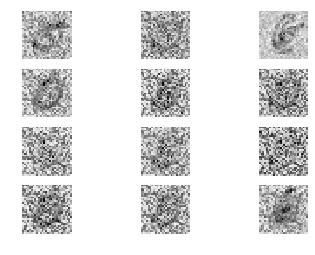

In [116]:
i=0
for r in range(4):
    for c in range(3):
        plt.subplot(4,3,i+1)
        plt.imshow(W[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1